### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2

from sklearn.preprocessing import OneHotEncoder, StandardScaler


VERBOSE = 1
CV = 3 #[(slice(None), slice(None))]
TESTING = True

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-05-07 11:11:10.269767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 11:11:11.453475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 4

hyperparameterspace = {
    'epochs': ["interval-int", 1, 40],
    'batch_size': ["interval-int", 1, 200],
    'learning_rate': ["interval-log", 0.000000001, 0.1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Model definition

In [3]:
def relu_advanced(x):
    return K.relu(x)


ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(stddev=0.05, seed=42)


def create_model(learning_rate=0.0001, input_dim=10, number_layers=1, neurons_per_layer=20):
    # create model
    model = Sequential()
    model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                    kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
    for _ in range(number_layers):
        model.add(Dense(neurons_per_layer, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                        kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


### Optimization

######################################################################################################################################################
Current Dataset: 1 of 5 with id: 233211
The average value for target is: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])

################################################## Current Budget: 9 ##################################################

Performing grid search


2023-05-07 11:11:14.888960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


With Hyperparameters: 
epochs: 30
batch_size: 150
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.19512929519017538

Performing random search
With Hyperparameters: 
epochs: 24
batch_size: 27
learning_rate: 0.0001746378816554028
Best score with Random search: 0.19474614163239798

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 450.22118757801945 seconds
With Hyperparameters: 
epochs: 14.0
batch_size: 169.0
learning_rate: 0.003939958421331225
Best score with Bayesian Optimization: 0.17704050242900848

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 221615ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.2055354888240496
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
-0.1362039099136989
Resulting loss (Optimal point evaluated):
0.34473395844300586
Best score with Sparse Search: 0.2055354888240496 optimized: 0.34473395844300586
[0.19512929519017538]
[0.19474614163239798]
[0.17704050242900848]
[0.2055354888240496]
[0.34473395844300586]

################################################## Current Budget: 17 ########

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 564.6262792720227 seconds
With Hyperparameters: 
epochs: 30.647708931320405
batch_size: 150.60765228194643
learning_rate: 0.00015975652713526357
Best score with Bayesian Optimization: 0.173094113667806

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 412547ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 150.25
learning_rate: 0.001
Resulting loss:
0.18912950654824578
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 199.99984747845113
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.08549415715727815
Resulting loss (Optimal point evaluated):
0.7635482201973597
Best score with Sparse Search: 0.18912950654824578 optimized: 0.7635482201973597
[0.19512929519017538, 0.18556792537371317]
[0.19474614163239798, 0.19177819788455963]
[0.17704050242900848, 0.173094113667806]
[0.2055354888240496, 

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 1402.4637646620977 seconds
With Hyperparameters: 
epochs: 22.41473129094607
batch_size: 99.58503831284303
learning_rate: 0.00043757341522298004
Best score with Bayesian Optimization: 0.1821699837843577

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 1205517ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.17646891872088113
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.50000008733252
batch_size: 85.40572673133612
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.14362809362020476
Resulting loss (Optimal point evaluated):
0.1782268832127253
Best score with Sparse Search: 0.17646891872088113 optimized: 0.1782268832127253
[0.19512929519017538, 0.18556792537371317, 0.19256991147994995, 0.1872436155875524]
[0.19474614163239798, 0.19177819788455963, 0.1853350

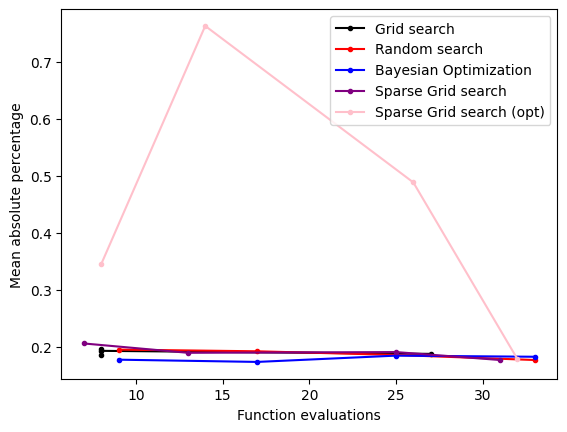

######################################################################################################################################################
Current Dataset: 2 of 5 with id: 359952
The average value for target is: tensor([50076.3906])
Min target: tensor([0.]) Max target: tensor([500001.])

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 30
batch_size: 50
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.3743178645769755

Performing random search
With Hyperparameters: 
epochs: 30
batch_size: 159
learning_rate: 9.642262487179352e-05
Best score with Random search: 0.40247776110967

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 227.20738222598447 seconds
With Hyperparameters: 
epochs: 23.0
batch_size: 56.0
learning_rate: 0.0005032855731039986
Best score with Bayesian Optimization: 0.32793782154719037

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 100309ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.37552791833877563
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.1898135542869568
Resulting loss (Optimal point evaluated):
2.838207244873047
Best score with Sparse Search: 0.37552791833877563 optimized: 2.838207244873047
[0.3743178645769755]
[0.40247776110967]
[0.32793782154719037]
[0.37552791833877563]
[2.838207244873047]

################################################## Current Budget: 17 ################

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 228.84055067499867 seconds
With Hyperparameters: 
epochs: 13.43606683036573
batch_size: 101.37653423992018
learning_rate: 0.0014695217135768151
Best score with Bayesian Optimization: 0.36834338307380676

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 186814ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 150.25
learning_rate: 0.001
Resulting loss:
0.3417559464772542
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 199.99985918632396
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.11344239540847717
Resulting loss (Optimal point evaluated):
0.44746580719947815
Best score with Sparse Search: 0.3417559464772542 optimized: 0.44746580719947815
[0.3743178645769755, 0.3498578667640686]
[0.40247776110967, 0.36178632577260333]
[0.32793782154719037, 0.36834338307380676]
[0.37552791833877563, 0

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 398.634684308985 seconds
With Hyperparameters: 
epochs: 39.0
batch_size: 158.0
learning_rate: 0.00071320460551215
Best score with Bayesian Optimization: 0.3346227804819743

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 453526ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 50.75
learning_rate: 0.001
Resulting loss:
0.3167386054992676
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 50.75
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.3167386054992676
Resulting loss (Optimal point evaluated):
0.39798539876937866
Best score with Sparse Search: 0.3167386054992676 optimized: 0.39798539876937866
[0.3743178645769755, 0.3498578667640686, 0.3523576557636261]
[0.40247776110967, 0.36178632577260333, 0.35214948654174805]
[0.32793782154719037, 0.36834338307380676, 0.3346227804819743]
[0.37552

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 1576.3424113579676 seconds
With Hyperparameters: 
epochs: 33.13528305945308
batch_size: 24.902604911819914
learning_rate: 0.000670607231451147
Best score with Bayesian Optimization: 0.32825299104054767

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 529488ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.32768842577934265
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.32768842577934265
Resulting loss (Optimal point evaluated):
0.3456270098686218
Best score with Sparse Search: 0.32768842577934265 optimized: 0.3456270098686218
[0.3743178645769755, 0.3498578667640686, 0.3523576557636261, 0.32174307107925415]
[0.40247776110967, 0.36178632577260333, 0.35214948654174805, 0.35291316111882526

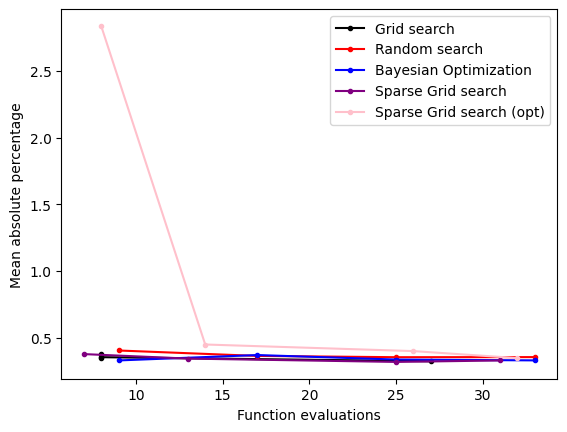

######################################################################################################################################################
Current Dataset: 3 of 5 with id: 359931
The average value for target is: tensor([15.0746])
Min target: tensor([12.5000]) Max target: tensor([17.5000])

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 10
batch_size: 150
learning_rate: 4.6415888336127847e-07
Best score with Grid search: 0.04326933994889259

Performing random search
With Hyperparameters: 
epochs: 15
batch_size: 16
learning_rate: 4.3647402367304505e-06
Best score with Random search: 0.043312585602204

Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 19.660857483104337 seconds
With Hyperparameters: 
epochs: 25.914739280922685
batch_size: 161.46274708068276
learning_rate: 3.261114100141249e-09
Best score with Bayesian Optimization: 0.04363273580869039

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 14727ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 150.25
learning_rate: 1e-05
Resulting loss:
0.04381973668932915
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 200.0
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.04244503006339073
Resulting loss (Optimal point evaluated):
0.044951031605402626
Best score with Sparse Search: 0.04381973668932915 optimized: 0.044951031605402626
[0.04326933994889259]
[0.043312585602204]
[0.04363273580869039]
[0.04381973668932915]
[0.044951031605402626]

##############################################

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 45.352725539996754 seconds
With Hyperparameters: 
epochs: 22.0
batch_size: 91.0
learning_rate: 3.7497218041599536e-05
Best score with Bayesian Optimization: 0.04356540615359942

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 27188ms.
Solving linear system (automatic method)...
Done in 0ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 100.5
learning_rate: 1.0000000000000001e-07
Resulting loss:
0.04365043838818868
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 100.5
learning_rate: 1.0000000000000001e-07
Resulting loss (Optimal value from optimization):
0.04365043838818868
Resulting loss (Optimal point evaluated):
0.04530939335624377
Best score with Sparse Search: 0.04365043838818868 optimized: 0.04530939335624377
[0.04326933994889259, 0.04398371527592341]
[0.043312585602204, 0.04385155191024145]
[0.04363273580869039, 0.04356540615359942]
[0.04381973668932915, 0.0

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 74.12195659099962 seconds
With Hyperparameters: 
epochs: 23.0
batch_size: 41.0
learning_rate: 8.501986177583157e-07
Best score with Bayesian Optimization: 0.04355102156599363

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 51611ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 25.375
batch_size: 100.5
learning_rate: 1e-05
Resulting loss:
0.04357608283559481
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 25.375
batch_size: 100.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.04357608283559481
Resulting loss (Optimal point evaluated):
0.043634213507175446
Best score with Sparse Search: 0.04357608283559481 optimized: 0.043634213507175446
[0.04326933994889259, 0.04398371527592341, 0.044148191809654236]
[0.043312585602204, 0.04385155191024145, 0.04423783098657926]
[0.04363273580869039, 0.04356540615359942, 0.0435510215

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 75.98521793901455 seconds
With Hyperparameters: 
epochs: 1.4095212663354129
batch_size: 106.28147819660182
learning_rate: 5.334227537395132e-07
Best score with Bayesian Optimization: 0.04368932172656059

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 67719ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 35.125
batch_size: 100.5
learning_rate: 1e-05
Resulting loss:
0.04320549716552099
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 35.125
batch_size: 100.5
learning_rate: 1e-05
Resulting loss (Optimal value from optimization):
0.04320549716552099
Resulting loss (Optimal point evaluated):
0.04391168306271235
Best score with Sparse Search: 0.04320549716552099 optimized: 0.04391168306271235
[0.04326933994889259, 0.04398371527592341, 0.044148191809654236, 0.043199690679709114]
[0.043312585602204, 0.04385155191024145, 0.04423783098657926, 0.04321

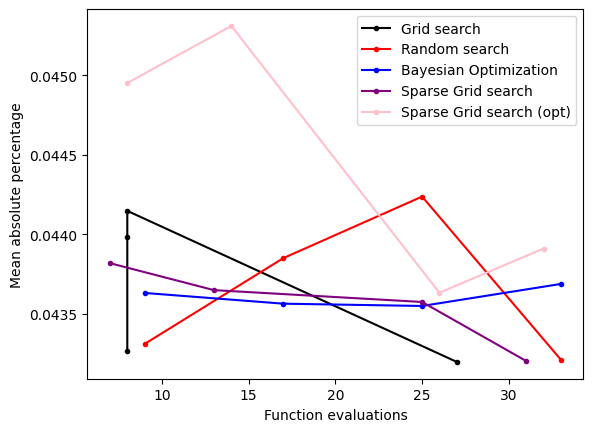

######################################################################################################################################################
Current Dataset: 4 of 5 with id: 359949
The average value for target is: tensor([540084.6250])
Min target: tensor([75000.]) Max target: tensor([7700000.])

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 30
batch_size: 50
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.12854776283105215

Performing random search
With Hyperparameters: 
epochs: 32
batch_size: 63
learning_rate: 0.0004769267921523007
Best score with Random search: 0.12821041544278464

Performing bayesian optimization
Iterations took 158.9131713360257 seconds
With Hyperparameters: 
epochs: 28.983567051067187
batch_size: 116.68097274953278
learning_rate: 0.0052158063812024254
Best score with Bayesian Optimization: 0.1291191230217615

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 521.4820544440299 seconds
With Hyperparameters: 
epochs: 24.0
batch_size: 75.0
learning_rate: 0.0023547333382271988
Best score with Bayesian Optimization: 0.12877479443947473

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 454049ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 50.75
learning_rate: 0.001
Resulting loss:
0.12625501056512198
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 50.75
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.12625501056512198
Resulting loss (Optimal point evaluated):
0.13007940351963043
Best score with Sparse Search: 0.12625501056512198 optimized: 0.13007940351963043
[0.12854776283105215, 0.12778827548027039, 0.12695693969726562]
[0.12821041544278464, 0.12712193032105765, 0.1259574219584465]
[0.12911912302176157, 0.12672251711289087, 0.128774794439474

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 806.8673268690764 seconds
With Hyperparameters: 
epochs: 21.16775041610675
batch_size: 85.24039560069681
learning_rate: 0.0008993390722571971
Best score with Bayesian Optimization: 0.12681741019090018

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 533261ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 150.25
learning_rate: 0.001
Resulting loss:
0.1261090636253357
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 39.99997031727997
batch_size: 199.9999699396099
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
-0.06395615596297964
Resulting loss (Optimal point evaluated):
0.2545158366362254
Best score with Sparse Search: 0.1261090636253357 optimized: 0.2545158366362254
[0.12854776283105215, 0.12778827548027039, 0.12695693969726562, 0.12555205325285593]
[0.12821041544278464, 0.12712193032105765, 0.12595742

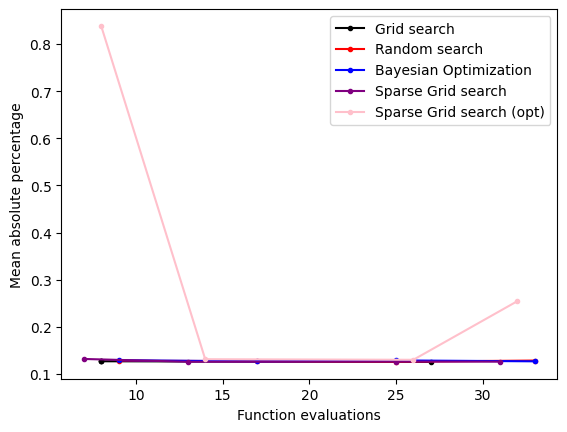

######################################################################################################################################################
Current Dataset: 5 of 5 with id: 359938
The average value for target is: tensor([5490.4849])
Min target: tensor([499.]) Max target: tensor([1120000.])

################################################## Current Budget: 9 ##################################################

Performing grid search
With Hyperparameters: 
epochs: 30
batch_size: 50
learning_rate: 0.0002154434690031884
Best score with Grid search: 0.04609496518969536

Performing random search
With Hyperparameters: 
epochs: 35
batch_size: 83
learning_rate: 0.007829082253950969
Best score with Random search: 0.03555896785110235

Performing bayesian optimization
Iterations took 131.29600080495584 seconds
With Hyperparameters: 
epochs: 31.484840306960805
batch_size: 69.8524328336725
learning_rate: 0.005586744360144044
Best score with Bayesian Optimization: 0.037668864242732525

Per

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 715.4331186810159 seconds
With Hyperparameters: 
epochs: 19.36862715814994
batch_size: 18.618746872995196
learning_rate: 0.0002847105631915972
Best score with Bayesian Optimization: 0.04187566911180814

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 103395ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 30.25
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.04099778396387893
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 30.25
batch_size: 100.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.04099778396387893
Resulting loss (Optimal point evaluated):
0.030631935844818752
Best score with Sparse Search: 0.04099778396387893 optimized: 0.030631935844818752
[0.04609496518969536, 0.059737760573625565]
[0.03555896785110235, 0.042794518172740936]
[0.037668864242732525, 0.04187566911180814]
[0.04274809236327809, 0.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 347.15254884801107 seconds
With Hyperparameters: 
epochs: 29.17698475966184
batch_size: 127.06448215933837
learning_rate: 0.005489266432556968
Best score with Bayesian Optimization: 0.03486972985168298

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 244000ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.04284660021464032
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 20.5
batch_size: 100.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.04284660021464032
Resulting loss (Optimal point evaluated):
0.05761006412406763
Best score with Sparse Search: 0.04284660021464032 optimized: 0.05761006412406763
[0.04609496518969536, 0.059737760573625565, 0.04795233656962713]
[0.03555896785110235, 0.042794518172740936, 0.0365925170481205]
[0.037668864242732525, 0.041875

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 574.1098282930034 seconds
With Hyperparameters: 
epochs: 33.000008681943335
batch_size: 95.99999565902525
learning_rate: 0.008780217773185441
Best score with Bayesian Optimization: 0.031156502664089203

Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 278298ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 30.25
batch_size: 100.5
learning_rate: 0.001
Resulting loss:
0.03871960875888665
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 30.25
batch_size: 100.5
learning_rate: 0.001
Resulting loss (Optimal value from optimization):
0.03871960875888665
Resulting loss (Optimal point evaluated):
0.037681493908166885
Best score with Sparse Search: 0.03871960875888665 optimized: 0.037681493908166885
[0.04609496518969536, 0.059737760573625565, 0.04795233656962713, 0.028009433920184772]
[0.03555896785110235, 0.042794518172740936, 0.0365925170481205, 0.042

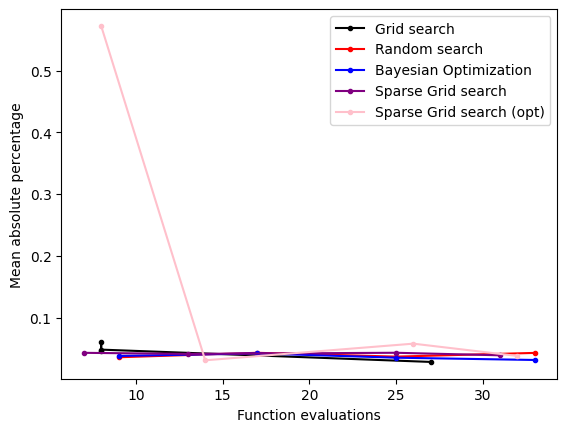

In [4]:
ids = [233211, 359952, 359931, 359949, 359938]
# [359940, 317614, 359934, 359946, 359932, 233214, 359943]

valid_datasets = 0

for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    print("The average value for target is:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    current_dataset_grid = []
    current_dataset_random = []
    current_dataset_bayesian = []
    current_dataset_sparse = []
    current_dataset_sparse_opt = []

    current_dataset_grid_cost = []
    current_dataset_random_cost = []
    current_dataset_bayesian_cost = []
    current_dataset_sparse_cost = []
    current_dataset_sparse_opt_cost = []

    ################## MODEL AND FUNCTION DEFINITION ####################

    def evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer):

        # return epochs + batch_size + learning_rate + number_of_layers + neurons_per_layer

        kfold = KFold(n_splits=CV)

        split = (kfold.split(dataset.get_X(), dataset.get_Y()))

        values = []

        numeric_features = [not x for x in dataset.get_categorical_indicator()]
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(
                    handle_unknown="infrequent_if_exist", sparse_output=False)),
                # ("selector", SelectPercentile(chi2, percentile=50)),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer,
                 dataset.get_categorical_indicator()),
            ]
        )

        for i, (train_index, test_index) in enumerate(split):
            X_train = dataset.get_X()[train_index]
            Y_train = dataset.get_Y()[train_index]

            X_val = dataset.get_X()[test_index]
            Y_val = dataset.get_Y()[test_index]

            preprocessor.fit(X_train, Y_train)

            X_train = preprocessor.transform(X_train)
            X_val = preprocessor.transform(X_val)

            regressor = TransformedTargetRegressor(regressor=KerasRegressor(model=create_model,
                                                                            learning_rate=learning_rate,
                                                                            input_dim=len(
                                                                                X_train[0]),
                                                                            number_layers=number_of_layers,
                                                                            neurons_per_layer=neurons_per_layer,
                                                                            verbose=0),
                                                   transformer=StandardScaler())

            regressor.fit(X_train, Y_train, epochs=epochs,
                          batch_size=batch_size)

            Y_predicted = regressor.predict(X_val)
            # error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
            error = sklearn.metrics.mean_absolute_percentage_error(
                Y_predicted, Y_val)
            values.append(error)

            K.clear_session()

        result = sum(values)/len(values)
        return result

    def blackboxfunction(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = int(params[1])

        learning_rate = params[2]

        number_of_layers = 1 # int(params[3])

        neurons_per_layer = 30 # int(params[4])

        return evaluate_model(epochs, batch_size, learning_rate, number_of_layers, neurons_per_layer)

    def blackboxfunction_bayesian(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]

        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = 10 ** (params[2])

        number_of_layers = 1 # int(params[3])

        neurons_per_layer = 30 # int(params[4])

        return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(
                len(hyperparameterspace.keys()))

        def eval(self, x):
            # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            # hyperparameterspace_special["loss"][index]

            epochs = int(HPO.from_standard(
                hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(
                hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["learning_rate"][
                                                        0], hyperparameterspace_special["learning_rate"][1], x[2])

            number_of_layers = 1 # int(HPO.from_standard(
                # hyperparameterspace_special["number_layers"][0], hyperparameterspace_special["number_layers"][1], x[3]))

            neurons_per_layer = 30 # int(HPO.from_standard(
                # hyperparameterspace_special["neurons_per_layer"][0], hyperparameterspace_special["neurons_per_layer"][1], x[4]))

            return evaluate_model(epochs, batch_size, model_learning_rate, number_of_layers, neurons_per_layer)

    ##### For each dataset: run models with different budget #####
    BUDGET = 1
    for j in range(ITER):
        
        BUDGET = BUDGET + 2 ** len(hyperparameterspace.keys())

        print("\n################################################## Current Budget:",
              BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("\nPerforming grid search")

        optimization = HPO.GridSearchOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            m = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[m]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[m]))
                m += 1

        print("Best score with Grid search:", best_score)

        current_dataset_grid.append(best_score)
        current_dataset_grid_cost.append(cost)

        K.clear_session()

        # ########################### RANDOM SEARCH #######################
        print("\nPerforming random search")

        optimization = HPO.RandomSearchOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            m = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[m]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[m]))
                m += 1

        
        print("Best score with Random search:", best_score)

        current_dataset_random.append(best_score)
        current_dataset_random_cost.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT #####################
        print("\nPerforming bayesian optimization")

        optimization = HPO.BayesianOptimization(
            dataset, blackboxfunction_bayesian, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] < result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            m = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[m]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                elif hyperparameterspace[key][0] == "interval-log":
                    print(key + ": " + str(10 ** best_params[m]))
                else:
                    print(key + ": " + str(best_params[m]))
                m += 1

        
        print("Best score with Bayesian Optimization:", best_score)

        current_dataset_bayesian.append(best_score)
        current_dataset_bayesian_cost.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("\nPerforming sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(
            dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        print("Best score with Sparse Search:", result[0][1], "optimized:", result[0][3])


        current_dataset_sparse.append(result[0][1])
        current_dataset_sparse_opt.append(result[0][3])

        current_dataset_sparse_cost.append(result[1])
        current_dataset_sparse_opt_cost.append(result[1]+1)

        K.clear_session()

        print(current_dataset_grid)
        print(current_dataset_random)
        print(current_dataset_bayesian)
        print(current_dataset_sparse)
        print(current_dataset_sparse_opt)


   

    GRID_RESULT.append(current_dataset_grid)
    RANDOM_RESULT.append(current_dataset_random)
    BAYESIAN_RESULT.append(current_dataset_bayesian)
    SPARSE_RESULT.append(current_dataset_sparse)
    SPARSE_RESULT_OPTIMIZED.append(current_dataset_sparse_opt)

    GRID_COST.append(current_dataset_grid_cost)
    RANDOM_COST.append(current_dataset_random_cost)
    BAYESIAN_COST.append(current_dataset_bayesian_cost)
    SPARSE_COST.append(current_dataset_sparse_cost)
    SPARSE_COST_OPTIMIZED.append(current_dataset_sparse_opt_cost)


    print("###################### Current dataset", ids[i], "######################")
    
    dataset = HPO.Dataset(task_id=ids[i])
    
    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    # plotting the points 
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-', color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-', color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-', color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-', color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i], '.-', color='pink', label="Sparse Grid search (opt)")
    
    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute percentage')
    
    # show a legend on the plot
    plt.legend()
    plt.savefig("Current_tests/task_id"+str(ids[i]))
    # function to show the plot
    plt.show()


### Print lines

###################### Current dataset 233211 ######################
Target average: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])


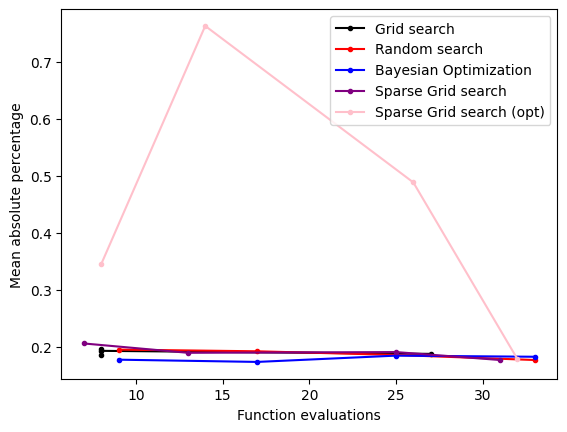

###################### Current dataset 359952 ######################
Target average: tensor([50076.3906])
Min target: tensor([0.]) Max target: tensor([500001.])


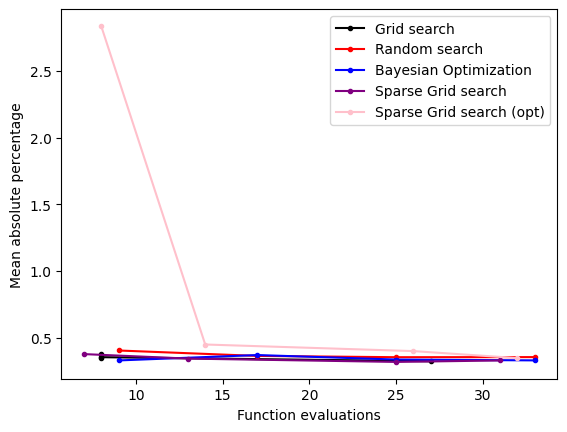

###################### Current dataset 359931 ######################
Target average: tensor([15.0746])
Min target: tensor([12.5000]) Max target: tensor([17.5000])


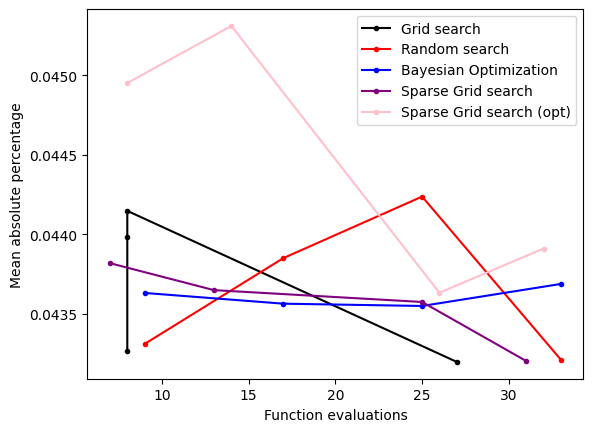

###################### Current dataset 359949 ######################
Target average: tensor([540084.6250])
Min target: tensor([75000.]) Max target: tensor([7700000.])


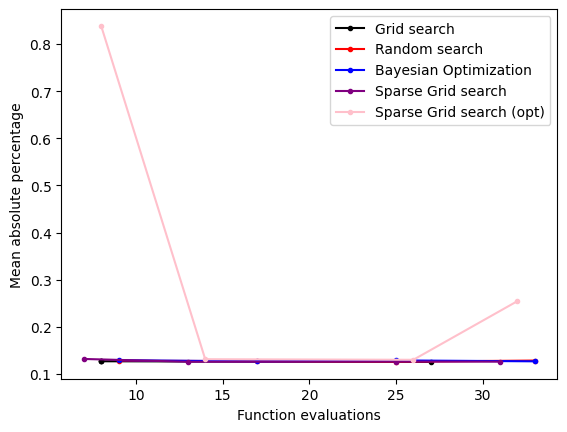

###################### Current dataset 359938 ######################
Target average: tensor([5490.4849])
Min target: tensor([499.]) Max target: tensor([1120000.])


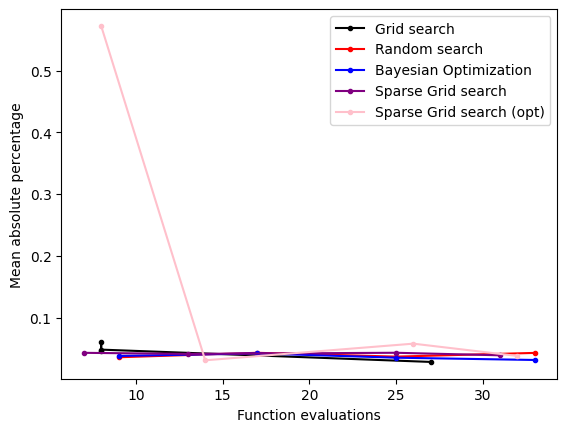

In [5]:
for i in range(len(ids)):
    print("###################### Current dataset", ids[i], "######################")
    
    dataset = HPO.Dataset(task_id=ids[i])
    
    print("Target average:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))


    # plotting the points 
    plt.plot(GRID_COST[i], GRID_RESULT[i], '.-', color='black', label="Grid search")
    plt.plot(RANDOM_COST[i], RANDOM_RESULT[i], '.-', color='red', label="Random search")
    plt.plot(BAYESIAN_COST[i], BAYESIAN_RESULT[i], '.-', color='blue', label="Bayesian Optimization")
    plt.plot(SPARSE_COST[i], SPARSE_RESULT[i], '.-', color='purple', label="Sparse Grid search")
    plt.plot(SPARSE_COST_OPTIMIZED[i], SPARSE_RESULT_OPTIMIZED[i], '.-', color='pink', label="Sparse Grid search (opt)")
    
    # naming the x axis
    plt.xlabel('Function evaluations')
    # naming the y axis
    plt.ylabel('Mean absolute percentage')
    
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()